<a href="https://colab.research.google.com/github/gautamankitkumar/ankitgau-ms-report-data/blob/main/notebooks/surface-relax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

The aim of this exercise is to check Neural Network (trained on unrelaxed structures) performance on DFT relaxed segregation energy of atomic swaps.

Neural Network is only checked for the case of Ag-Au swaps. Thus, a 2 x 2 x 5 slab is setup with a random but 1:1:1 composition of CuAgAu fixed at its calculated lattice constant via Vegard's law. Top two layers (8 atoms) are allowed to relax. These 8 atoms would form 256 possible combinations. Each of these have a distinct energy as enumerated by `EMT()`. 

# Procedure

1. Create 256 structures with possible AgAu positions.
2. Find energy of the structures with top two layers relaxed.
3. Compare NN predicted $\Delta E$ and DFT Relaxed $\Delta E$

## Note: Current results are for only 50 out of 256 structures

In [ ]:
! pip install ase
! git clone https://github.com/gautamankitkumar/ankitgau-ms-report-data.git
% cd ankitgau-ms-report-data
% cd notebooks
% cd utils
! python3 libsymf_builder.py
% cd ..
% cd ..
% cp data/local.db notebooks/
% cp data/small_list.txt notebooks/
% cp data/relax-energies.db notebooks/
% cd notebooks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import fcc111, fcc111_root
from ase.calculators.emt import EMT
import os
import torch
from utils.fcc_helpers import cal_nrg
from utils.train_agent import BPNN
from utils.fp_calculator import set_sym
from itertools import product

# This is needed for the error as the bug shown
# https://github.com/dmlc/xgboost/issues/1715#issuecomment-420305786
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from ase.db import connect

## Find energy unique structures

In [ ]:
# bulk spacing
lc_Cu, lc_Ag, lc_Au = 3.6387, 4.1628, 4.1733
lc = (lc_Cu + lc_Au + lc_Ag)/3
print(lc)

slab = fcc111('Ag', size=(2,2,5),a =lc, vacuum= 10.0)

# Bottom layers has already been randomized and fixed at same composition.
bottom_layers = ['Cu', 'Au', 'Ag', 'Cu', 'Ag', 'Au', 'Cu', 'Ag', 'Cu', 'Au', 'Ag', 'Au']

for i in range(len(bottom_layers)):
    slab[i].symbol = bottom_layers[i]

nrg_list = []

if os.path.exists('local.db'):
    os.remove('local.db')

db = connect('local.db')

comps = []
for i, c in enumerate(product(['Au','Ag'], repeat=8)):
    new_slab = slab.copy()
    for j, s in enumerate(range(12,20)):
        new_slab[s].symbol = c[j]
    
    new_slab.set_calculator(EMT())
    new_slab_en = new_slab.get_potential_energy()
    if (new_slab_en not in nrg_list):
        nrg_list.append(new_slab_en)
        db.write(atoms=new_slab)

print(len(nrg_list)) # 256

In [ ]:
def isNeighbor(x,y):
    """
    Determines if structure-x and structure-y are swap-neighbors
    
    Swap neighbors are defined as structures differing at exactly two positions. These two positions define the starting and ending position of a swap
    Given two lists of chemical symbols, returns True if one Ag atom can be swapped with its neighbors to achieve the second structure
    x: atoms object
    y: atoms object
    """
    
    # Get symbols
    x_sym = x.get_chemical_symbols()[12:]
    y_sym = y.get_chemical_symbols()[12:]
    
    # Compositions do not change because of swap
    if x_sym.count('Ag')==y_sym.count('Ag'):
        ans = np.array(x_sym) != np.array(y_sym)
        
        # Symbols should only differ at exactly two positions
        if ans.sum()==2:
            return True , np.where(ans==1)[0].tolist()
        else:
            return False , 0
    else:
        return False, 0

# Contains all swap neighbors. 1792 combinations 
big_list = []

# Contains swap neighbors where both structures are within the first 50 out of 256.
# Contains 166 combinations
small_list = []

for i in range(len(db)):
    for j in range(i+1,len(db)):
        res,val = isNeighbor(db.get_atoms(id=i+1),db.get_atoms(id=j+1))
        if res:
            if [i,j,*val] not in big_list:
                big_list.append([i,j,*val])
                if i < 50 and j < 50:
                    small_list.append([i,j,*val])
print(f'Combinations in only first 50/256 : {len(small_list):.0f}, All combinations {len(big_list):.0f}')

In [2]:
# Neural Network settings
Name = 'CuAgAu'
scale = torch.load(f'./{Name}/scale.sav')
layer_nodes = [10, 10]
activations = ['tanh', 'tanh']
elements_i = [29, 47, 79]
n_fp = 12
models = [BPNN(n_fp, layer_nodes, activations) for _ in elements_i]
model_paths = [f'./{Name}/model_for_{i}.sav' for i in elements_i]
for i in range(len(models)):
    models[i].load_state_dict(torch.load(model_paths[i], map_location=torch.device('cpu')))
elements = ['Cu', 'Ag', 'Au']  # [1, 2, 3 in the param_set]
Gs = [2]
cutoff = 6.0
g2_etas = [0.05, 4.0, 20.0, 80.0]
g2_Rses = [0.0]
params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses)

## Find difference in energies 

In [3]:
db_dft = connect ('relax-energies.db') # Contains relaxed structures energies
nn_db = connect('local.db') # Contains the possible 256 structures

Z = np.loadtxt('small_list.txt')

en = []
layer1_dft = []
layer2_dft = []


for [i,j,ele1,ele2] in Z:
    ref_en = db_dft.get_atoms(id=j+1).get_potential_energy() - db_dft.get_atoms(id=i+1).get_potential_energy()
    atoms = nn_db.get_atoms(id=j+1)
    nn_1 =  cal_nrg(models,atoms , params_set, elements, scale)
    atoms = nn_db.get_atoms(id=i+1)
    nn_2 =  cal_nrg(models, atoms, params_set, elements, scale)
    nn_en = nn_1 - nn_2
    en.append([ref_en,nn_en,ref_en - nn_en])
    
    # If the swap occurs within two layers. i.e. the starting and ending position are in two different layers
    
    # Inter-layer swap
    if (ele1<=3 and ele2>=4) or (ele1>=4 and ele2<=3):
        layer1_dft.append(np.sign(ref_en) * np.sign(nn_en))
    else:
        # Intra-layer swap
        layer2_dft.append(np.sign(ref_en) * np.sign(nn_en))

# Results

For each swap that is possible, find relaxed DFT energy and NN predicted energy.

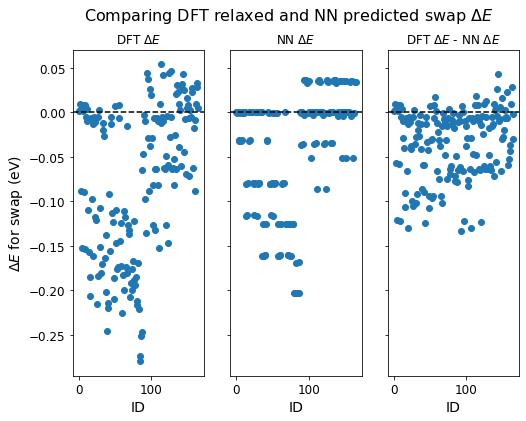

In [10]:
e = np.array(en)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(8,6))

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


ax1.plot(e[:,0],'o')
ax1.axhline(0,ls='--',color='k')
ax2.plot(e[:,1],'o')
ax2.axhline(0,ls='--',color='k')
ax3.plot(e[:,2],'o')
ax3.axhline(0,ls='--',color='k')
ax1.set_ylabel(r'$\Delta E$ for swap (eV)')
ax1.set_title(r'DFT $\Delta E$')
ax2.set_title(r'NN $\Delta E$')
ax3.set_title(r'DFT $\Delta E$ - NN $\Delta E$ ')
ax1.set_xlabel('ID'),ax2.set_xlabel('ID'), ax3.set_xlabel('ID')
fig.suptitle(r'Comparing DFT relaxed and NN predicted swap $\Delta E$')
plt.savefig('energy-comparison.png', dpi=300)

Atomic swap energies for AgAu vary from 0.05 eV to -0.25 eV. Yilin observed range of -0.5 eV to 1 eV for PdCu. The smaller range of AgAu is expected since this binary pair shows a lower segregation energy than that of PdCu. DFT $\Delta E$ is fairly random around the zero line. This is only a subset of all possible combinations. Neural Network $\Delta E$'s are more ordered. I expected this to happen becaue having a similar (symmetric, for example) environment would activate those specific nodes in the Neural Network. Neural Network predictions vary roughly around the same magnitude as that seen in DFT.

Lastly, the individual differences are plotted. We see that most of the points lie below the axis. I believe this is because the first 50 configurations are Au dominated as the structures are created by `itertools.product` enumeration. It may have happened a lot these correspond to Au segregation. I expect that third plot to be randomly distributed around the `y=0` line when plotted for all the configurations.

# Inter and Intra layer predictions

Individual corrections do not provide the most useful results. To see the effect on segregation, inter-layer and intra-layer segregation is obtained. For example, inter-layer exchange would occur when start and end of atomic swap reside in different layers (Layer-1 and Layer-2 in this case). I have plotted `sign(DFT) * sign(NN)` where `sign` is the `signum` function. This product of signum's would allow us to see whether DFT and NN prediction lie on the same side of `y=0`. If both are negative or positive, we expect a positive product. If they do not share the same sign, this means that a negative product is obtained.

Plot-1 shows inter-layer signum product. Nearly all of the energy swaps are predicted with a correct sign by Neural Network. Only 2 out of 176 are predicted incorrectly. This goes on to say that the sign of atomic swap energy change that would have occurred if we had employed relaxed DFT calculations, is being captured correctly by our Neural Network. Consequently, the Neural Network actually replicates the atomic swap energies in Monte Carlo simulations. 

Plot-2 shows intra-layer exchange. There exists almost half of the points on either side of `y=0`. This result doesn't change any of the segregation trend since the swaps occur within a single layer.

78


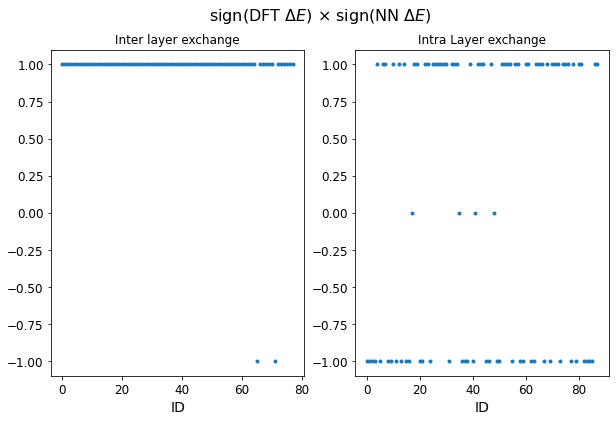

In [8]:
print(len(layer1_dft))
lay1,lay2 = np.array(layer1_dft), np.array(layer2_dft)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,6))
ax1.plot(layer1_dft,'.')
ax2.plot(layer2_dft,'.')
ax1.set_title(r'Inter layer exchange')
ax2.set_title(r'Intra Layer exchange')
ax1.set_xlabel('ID'),ax2.set_xlabel('ID')
f.suptitle(r'sign(DFT $\Delta E$) $\times$ sign(NN $\Delta E$)')
plt.show()

# Conclusion

With the 50 configurations out of 256 possible AgAu combinations in top two layers of 2 x 2 x 5 slab, 176 out of 1792 atomic swaps are analyzed and the swap energies compared. It is observed that Neural Network trained on unrelaxed configurations accurately captures the same sign trend as would have occurred in relaxed DFT energy swaps. With more of the data available, the result can be strengthened even more.